In [ ]:
# set tf 1.x for colab
%tensorflow_version 1.x

# MNIST digits classification with TensorFlow

<img src="images/mnist_sample.png" style="width:30%">

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
print("We're using TF", tf.__version__)

import sys
sys.path.append("../..")
import grading

import matplotlib_utils
from importlib import reload
reload(matplotlib_utils)

import grading_utils
reload(grading_utils)

import keras_utils
from keras_utils import reset_tf_session

We're using TF 1.15.0


Using TensorFlow backend.


# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [2]:
grader = grading.Grader(assignment_key="XtD7ho3TEeiHQBLWejjYAA", 
                        all_parts=["9XaAS", "vmogZ", "RMv95", "i8bgs", "rE763"])

In [3]:
# token expires every 30 min
COURSERA_TOKEN = "WAQGqxHk0HbtU5BK"
COURSERA_EMAIL = "diletta.calussi@gmail.com"

# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [4]:
import preprocessed_mnist
X_train, y_train, X_val, y_val, X_test, y_test = preprocessed_mnist.load_dataset()

X_train [shape (50000, 28, 28)] sample patch:
 [[0.         0.29803922 0.96470588 0.98823529 0.43921569]
 [0.         0.33333333 0.98823529 0.90196078 0.09803922]
 [0.         0.33333333 0.98823529 0.8745098  0.        ]
 [0.         0.33333333 0.98823529 0.56862745 0.        ]
 [0.         0.3372549  0.99215686 0.88235294 0.        ]]
A closeup of a sample patch:


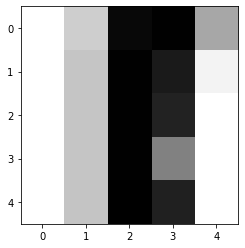

And the whole sample:


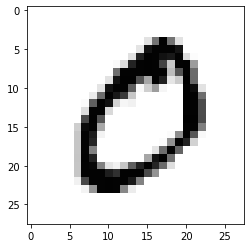

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [5]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

# Linear model

Your task is to train a linear classifier $\vec{x} \rightarrow y$ with SGD using TensorFlow.

You will need to calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

And transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

We will use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

Here's the plan:
* Flatten the images (28x28 -> 784) with `X_train.reshape((X_train.shape[0], -1))` to simplify our linear model implementation
* Use a matrix placeholder for flattened `X_train`
* Convert `y_train` to one-hot encoded vectors that are needed for cross-entropy
* Use a shared variable `W` for all weights (a column $\vec{w_k}$ per class) and `b` for all biases.
* Aim for ~0.93 validation accuracy

In [6]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
print(X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [7]:
import keras

y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:3], y_train[:3])

(50000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


In [8]:
# run this again if you remake your graph
s = reset_tf_session()

In [10]:
# Model parameters: W and b
W = tf.get_variable("W", dtype = tf.float32, shape=(784, 10), trainable = True) ### YOUR CODE HERE ### tf.get_variable(...) with shape[0] = 784
b = tf.get_variable("b", dtype = tf.float32, shape=(10, )) ### YOUR CODE HERE ### tf.get_variable(...)

In [11]:
# Placeholders for the input data
input_X = tf.placeholder(tf.float32, shape=(None, 784)) ### YOUR CODE HERE ### tf.placeholder(...) for flat X with shape[0] = None for any batch size
input_y = tf.placeholder(tf.float32, shape=(None, 10)) ### YOUR CODE HERE ### tf.placeholder(...) for one-hot encoded true labels

In [12]:
# Compute predictions
logits = input_X @ W + b ### YOUR CODE HERE ### logits for input_X, resulting shape should be [input_X.shape[0], 10]
probas = tf.nn.softmax(logits) ### YOUR CODE HERE ### apply tf.nn.softmax to logits
classes = tf.argmax(probas, 1) ### YOUR CODE HERE ### apply tf.argmax to find a class index with highest probability

# Loss should be a scalar number: average loss over all the objects with tf.reduce_mean().
# Use tf.nn.softmax_cross_entropy_with_logits on top of one-hot encoded input_y and logits.
# It is identical to calculating cross-entropy on top of probas, but is more numerically friendly (read the docs).
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = input_y)) ### YOUR CODE HERE ### cross-entropy loss

# Use a default tf.train.AdamOptimizer to get an SGD step
step = tf.train.AdamOptimizer().minimize(loss) ### YOUR CODE HERE ### optimizer step that minimizes the loss

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [13]:
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvPfjt%2B1J8FP2b5NGsfil4g1Maj4ilnTQNB8OeF9R1zVNR8lVed4bHTbee5kjiVkMkixlI96biu5c%2BhV4N%2B0P8D/j5/wANJ%2BDv2tv2bLLwfrWueH/B2seFNX8KeOdcutLtLywv7mwuxcQXtraXj288U2noCpt3WVJSCUKK1ABpf/BTL9izWLvxNb2nxXv0h8FWsk/jLUrvwXrEFjoIS0iu9l5dy2iwWsrQzRskMjrJIWKorMrKL2n/APBQ/wDZK1HwBrXxFTx/q9vB4f1ay0vVdE1DwNrNrrkV5ebfscC6PNaLqEr3AYGER27eaAxTcFYjy2b9gH4y%2BMf2a/jn8NfGHinwppHin4o/FS38daHc6U1xeWFpeW0OiywQ3IkihkkiN3pRRwoyYHGDuJVaPi79i/8AaV%2BLmr/Ef45fG34S/CjWvFnjWx8KaPp/gKy%2BI2s2Wm6fY6Hcaldw3qa7b6al5DqDXOqTOksVoPJSKNFZiWcgHsviH9vv9mzwv4a8OeI9XvvG3meK0v5NE8P2vwm8SXGuSRWUscV3NJpMWntf28MLzQq8s0CIpmiy37xM%2Bmaz8RPBHhv4e3XxX8T%2BJbbSvDljo76rf6vqrfZYbSySIzPPMZdvlKsYLNvxtAOcYNfGHin9hH9s/WPgV4X8Nay3hfxV470a58RHRfGd/wDHbxNpGr%2BCLW%2BuUktLO11q1sJLzXIYkjhWZb1YftJtovMBCjHqPxo/4J0Wvx6/Zu8T/Dj4hfHPxrd%2BO/GHwvj8M694pbxtrQ0ea%2BW0hibUE0Jb5bC3Z5oFlbyIopCHkAkVpGcgHRwf8FKP2Mv%2BFc%2BK/itrHxWvdE0bwRZWV94ofxP4O1fSbmysryYw2t79lvLWK4ktJZFZUuY42hby3IfCMRyHxu/4Kyfs7/DP4Iap8Y/Aei%2BKvFU2g/EHwv4X13wx/wAILrtjqdgdZ1K1tY7p7OTTmuvK8i4eeBvJ8u8eNLeGQyTxg%2BV6p/wTE%2BMnjv4VePtI8ReBvDejeMfEeh6Po9h4h1X9ovxn43W7tLXWLfUJo5P7dgP2CM%2BSxSKJZjvfDSYyT3/7UP7Bnxp%2BMHxB%2BL/xB8C%2BIfC8cni%2BD4W3nhKz1a%2BuYle/8J%2BI7nWpYbxo7eTyIbgNbwrLGJnXLsY/kVXAPULD/goJ%2By3qPxNsvgzD4n8TR%2BK7zRdP1iXQLv4b69Bc6dp9606QXd%2Bklkp06Hdbyq8l15SxEKJChdN1Hw1/wUw/Yp8W%2BDPFnxC0j4wXCaP4L8EXXjLWL3UPCWq2guPD1ujPNq1is9qjapZqqHE9mJ42LIFYl0DYOh/sh/FD4h/Ez43fEH44L4e0GL40fB3w74QurHwnrtxqMul3Fomupdss89na%2BZGBqsRifYrMUk3Rx4G75u/bG/ZU/ah0f9hj4pfE39pi78AWkPwh/Yp%2BIPgjwvH4C1C8uG15r3SLYz6jdLc20AsVCaRbhLONrgK00hM7bUFAH1n4e/4KS/sZeJtD1jxHp/xauoLPQ00qa%2Bk1TwlqtkzWmpXa2djqEK3FqjXNhLOwUX0Ie1UBnaVUVmHp%2BifF34eeI/ilr/wX0PxD9p8SeFtL0/UNfsI7SbbZwXzXAtd0xTyi7/ZZj5SuZFUIzKqyRlvknUP2Z/EHivQPFPxt/wCCkXi/4Z%2BE/Alv%2Bz3c/DqS48P%2BIJltZtNvZIZLzVbya9gt0sHJgthDbIZxATJ/pEhZcdh/wR88B/F2y/ZHtfj/APtIagb74k/F68j8T%2BK9Qeze3aSEWkFlpq%2BVJ88P/EutLSRomwUlmmyAxbIB9VUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV4jpH/AAUY/Y91K716z1P4pXnh5vDnhy58QahJ418I6roMc2k27pHPf2smpWsC31ujyRK0tsZUBljGcuufab2K5ms5YbO6EEzxMsUxj3%2BWxHDbT1wecd6/MTV/%2BCOX7cvxf1bwvrnxu%2BOOhvrfhrwfqFnqHijUPit4m8TjxDrf2zSr611E6XfRQ2Wk20lzpi%2BfYWQCiOTassgVAoB9sv8At/8A7MNr8NG%2BLGseIPFWlaW2uQaNY2eufDLX7DVNTv5kMkMFlptxYpe37SIGdfs8MgZUdgSEYjovAf7VnwP%2BI%2Bv2XhPw54h1SHV7/wAKT%2BJIdI1rwrqWmXaabDd/ZJZZYby3ikgdZ/kMMirL32bea8m%2BJ3wc/bd%2BMTfD342654N%2BFWh/EP4UeOptY8P%2BGbXxxqV/ouuWdxpN3plzHcXz6VDNYzFL2SSN0tbgRmIKfMEjYq/En4Dftwa/8ZfDv7TXgfRvhXaeLL74Yar4L8Y6FqXivUpLDSFuL%2BG6tb%2ByuE04SagYhG6yW8sVoJS4xLFjkA7jSf8Ago3%2ByB4j17wL4W8K/EbVdZ1P4k%2BDdK8W%2BDdO0TwPrN7PeaHqL7LXUZEgtGa1t92PMknEa24ZTN5QYE7Hw1/bc/Zu%2BK/xGufhP4Z8X6tZ6/b6Xc6nDZeJ/BmraIt/Y28iRz3dlLqNrBHfwRvLEHltmkRfMQkgMpPlH7Cn7CXxY/Zh1/4caz488QeGrs%2BDv2UvCPwxv30i5nlZtW0t5muZovMgj3Wrb02MxV22/NGmBXjXw0/4JV/tjeJ/ij4X8TftTfGGz1SLT/AHivwv408TQfF/xJrV54il1exS2/tO10y%2Bhj0/QjlSxtLRSi5UCZxGq0AfUvhP/gov%2ByP410WPxVoPjvXP7DuNV0vT9P8AEt78P9btdK1GXUr2OyspLS%2Bns0tryCW5mijFxBI8IMqFnCsCfS/C3xd%2BHnjX4geKfhd4X8Q/a9c8FyWcfie0S0mC2Ml1B9ogjMrII3doSshRGZkWSMsFEibvmHxx4E%2BIvhX/AIJ7eNPgR/wUM8T/AAq8EeAtB%2BGkWgW3xM8O%2BLbsM06RpbWupPaXVnAmmzLMLeSGCO4umM5REcnaG7X/AIJX/D74seG/2RNK%2BKv7RVglv8TvixfS%2BOviJClu0X2e/v1jMNpsb5k%2By2MdlZ7TkgWuDQB9G0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRR

# Submit a linear model

In [14]:
## GRADED PART, DO NOT CHANGE!
# Testing shapes 
grader.set_answer("9XaAS", grading_utils.get_tensors_shapes_string([W, b, input_X, input_y, logits, probas, classes]))
# Validation loss
grader.set_answer("vmogZ", s.run(loss, {input_X: X_val_flat, input_y: y_val_oh}))
# Validation accuracy
grader.set_answer("RMv95", accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

In [15]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# MLP with hidden layers

Previously we've coded a dense layer with matrix multiplication by hand. 
But this is not convenient, you have to create a lot of variables and your code becomes a mess. 
In TensorFlow there's an easier way to make a dense layer:
```python
hidden1 = tf.layers.dense(inputs, 256, activation=tf.nn.sigmoid)
```

That will create all the necessary variables automatically.
Here you can also choose an activation function (remember that we need it for a hidden layer!).

Now define the MLP with 2 hidden layers and restart training with the cell above.

You're aiming for ~0.97 validation accuracy here.

In [16]:
# write the code here to get a new `step` operation and then run the cell with training loop above.
# name your variables in the same way (e.g. logits, probas, classes, etc) for safety.
### YOUR CODE HERE ###
hidden1 = tf.layers.dense(input_X, 256, activation = tf.nn.sigmoid)
hidden2 = tf.layers.dense(hidden1, 256, activation = tf.nn.sigmoid)
logits = tf.layers.dense(hidden2, 10)

probas = tf.nn.softmax(logits)
classes = tf.argmax(probas, 1)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = input_y)) 
step = tf.train.AdamOptimizer().minimize(loss)

s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvPfjt%2B1J8FP2b5NGsfil4g1Maj4ilnTQNB8OeF9R1zVNR8lVed4bHTbee5kjiVkMkixlI96biu5c%2BhV4N%2B0P8D/j5/wANJ%2BDv2tv2bLLwfrWueH/B2seFNX8KeOdcutLtLywv7mwuxcQXtraXj288U2noCpt3WVJSCUKK1ABpf/BTL9izWLvxNb2nxXv0h8FWsk/jLUrvwXrEFjoIS0iu9l5dy2iwWsrQzRskMjrJIWKorMrKL2n/APBQ/wDZK1HwBrXxFTx/q9vB4f1ay0vVdE1DwNrNrrkV5ebfscC6PNaLqEr3AYGER27eaAxTcFYjy2b9gH4y%2BMf2a/jn8NfGHinwppHin4o/FS38daHc6U1xeWFpeW0OiywQ3IkihkkiN3pRRwoyYHGDuJVaPi79i/8AaV%2BLmr/Ef45fG34S/CjWvFnjWx8KaPp/gKy%2BI2s2Wm6fY6Hcaldw3qa7b6al5DqDXOqTOksVoPJSKNFZiWcgHsviH9vv9mzwv4a8OeI9XvvG3meK0v5NE8P2vwm8SXGuSRWUscV3NJpMWntf28MLzQq8s0CIpmiy37xM%2Bmaz8RPBHhv4e3XxX8T%2BJbbSvDljo76rf6vqrfZYbSySIzPPMZdvlKsYLNvxtAOcYNfGHin9hH9s/WPgV4X8Nay3hfxV470a58RHRfGd/wDHbxNpGr%2BCLW%2BuUktLO11q1sJLzXIYkjhWZb1YftJtovMBCjHqPxo/4J0Wvx6/Zu8T/Dj4hfHPxrd%2BO/GHwvj8M694pbxtrQ0ea%2BW0hibUE0Jb5bC3Z5oFlbyIopCHkAkVpGcgHRwf8FKP2Mv%2BFc%2BK/itrHxWvdE0bwRZWV94ofxP4O1fSbmysryYw2t79lvLWK4ktJZFZUuY42hby3IfCMRyHxu/4Kyfs7/DP4Iap8Y/Aei%2BKvFU2g/EHwv4X13wx/wAILrtjqdgdZ1K1tY7p7OTTmuvK8i4eeBvJ8u8eNLeGQyTxg%2BV6p/wTE%2BMnjv4VePtI8ReBvDejeMfEeh6Po9h4h1X9ovxn43W7tLXWLfUJo5P7dgP2CM%2BSxSKJZjvfDSYyT3/7UP7Bnxp%2BMHxB%2BL/xB8C%2BIfC8cni%2BD4W3nhKz1a%2BuYle/8J%2BI7nWpYbxo7eTyIbgNbwrLGJnXLsY/kVXAPULD/goJ%2By3qPxNsvgzD4n8TR%2BK7zRdP1iXQLv4b69Bc6dp9606QXd%2Bklkp06Hdbyq8l15SxEKJChdN1Hw1/wUw/Yp8W%2BDPFnxC0j4wXCaP4L8EXXjLWL3UPCWq2guPD1ujPNq1is9qjapZqqHE9mJ42LIFYl0DYOh/sh/FD4h/Ez43fEH44L4e0GL40fB3w74QurHwnrtxqMul3Fomupdss89na%2BZGBqsRifYrMUk3Rx4G75u/bG/ZU/ah0f9hj4pfE39pi78AWkPwh/Yp%2BIPgjwvH4C1C8uG15r3SLYz6jdLc20AsVCaRbhLONrgK00hM7bUFAH1n4e/4KS/sZeJtD1jxHp/xauoLPQ00qa%2Bk1TwlqtkzWmpXa2djqEK3FqjXNhLOwUX0Ie1UBnaVUVmHp%2BifF34eeI/ilr/wX0PxD9p8SeFtL0/UNfsI7SbbZwXzXAtd0xTyi7/ZZj5SuZFUIzKqyRlvknUP2Z/EHivQPFPxt/wCCkXi/4Z%2BE/Alv%2Bz3c/DqS48P%2BIJltZtNvZIZLzVbya9gt0sHJgthDbIZxATJ/pEhZcdh/wR88B/F2y/ZHtfj/APtIagb74k/F68j8T%2BK9Qeze3aSEWkFlpq%2BVJ88P/EutLSRomwUlmmyAxbIB9VUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV4jpH/AAUY/Y91K716z1P4pXnh5vDnhy58QahJ418I6roMc2k27pHPf2smpWsC31ujyRK0tsZUBljGcuufab2K5ms5YbO6EEzxMsUxj3%2BWxHDbT1wecd6/MTV/%2BCOX7cvxf1bwvrnxu%2BOOhvrfhrwfqFnqHijUPit4m8TjxDrf2zSr611E6XfRQ2Wk20lzpi%2BfYWQCiOTassgVAoB9sv8At/8A7MNr8NG%2BLGseIPFWlaW2uQaNY2eufDLX7DVNTv5kMkMFlptxYpe37SIGdfs8MgZUdgSEYjovAf7VnwP%2BI%2Bv2XhPw54h1SHV7/wAKT%2BJIdI1rwrqWmXaabDd/ZJZZYby3ikgdZ/kMMirL32bea8m%2BJ3wc/bd%2BMTfD342654N%2BFWh/EP4UeOptY8P%2BGbXxxqV/ouuWdxpN3plzHcXz6VDNYzFL2SSN0tbgRmIKfMEjYq/En4Dftwa/8ZfDv7TXgfRvhXaeLL74Yar4L8Y6FqXivUpLDSFuL%2BG6tb%2ByuE04SagYhG6yW8sVoJS4xLFjkA7jSf8Ago3%2ByB4j17wL4W8K/EbVdZ1P4k%2BDdK8W%2BDdO0TwPrN7PeaHqL7LXUZEgtGa1t92PMknEa24ZTN5QYE7Hw1/bc/Zu%2BK/xGufhP4Z8X6tZ6/b6Xc6nDZeJ/BmraIt/Y28iRz3dlLqNrBHfwRvLEHltmkRfMQkgMpPlH7Cn7CXxY/Zh1/4caz488QeGrs%2BDv2UvCPwxv30i5nlZtW0t5muZovMgj3Wrb02MxV22/NGmBXjXw0/4JV/tjeJ/ij4X8TftTfGGz1SLT/AHivwv408TQfF/xJrV54il1exS2/tO10y%2Bhj0/QjlSxtLRSi5UCZxGq0AfUvhP/gov%2ByP410WPxVoPjvXP7DuNV0vT9P8AEt78P9btdK1GXUr2OyspLS%2Bns0tryCW5mijFxBI8IMqFnCsCfS/C3xd%2BHnjX4geKfhd4X8Q/a9c8FyWcfie0S0mC2Ml1B9ogjMrII3doSshRGZkWSMsFEibvmHxx4E%2BIvhX/AIJ7eNPgR/wUM8T/AAq8EeAtB%2BGkWgW3xM8O%2BLbsM06RpbWupPaXVnAmmzLMLeSGCO4umM5REcnaG7X/AIJX/D74seG/2RNK%2BKv7RVglv8TvixfS%2BOviJClu0X2e/v1jMNpsb5k%2By2MdlZ7TkgWuDQB9G0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRR

# Submit the MLP with 2 hidden layers
Run these cells after training the MLP with 2 hidden layers

In [17]:
## GRADED PART, DO NOT CHANGE!
# Validation loss for MLP
grader.set_answer("i8bgs", s.run(loss, {input_X: X_val_flat, input_y: y_val_oh}))
# Validation accuracy for MLP
grader.set_answer("rE763", accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

In [18]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!
